In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from multi_group_simulation import MultiGroupSimulation
from stochastic_simulation import StochasticSimulation
from load_params import load_params

In [24]:
def single_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, perform_contact_tracing):
    base_config_loc="/home/jmc678/covid_data/group-testing/src/simulations_v2/params/"\
                "june8params/noreopen/nominal_students.yaml"
    _, base_config = load_params(base_config_loc)
    base_config['test_population_fraction'] = test_rate
    base_config['expected_contacts_per_day'] = daily_contacts
    base_config['population_size'] = pop_size
    base_config['daily_outside_infection_p'] = outside_infection_p
    base_config['init_ID_prevalence_stochastic'] = True
    base_config['perform_contact_tracing'] = perform_contact_tracing
    return base_config

def multi_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, perform_contact_tracing, num_groups):
    base_configs = [single_group_config(pop_size / num_groups, 
                                        daily_contacts / num_groups, 
                                        test_rate, 
                                        outside_infection_p,
                                        perform_contact_tracing)] * num_groups
    interaction_matrix = np.matrix([[daily_contacts/num_groups] * num_groups] * num_groups)
    return base_configs, interaction_matrix

In [17]:
pop_size = 1000
daily_contacts = 10
test_rate = 0.2
outside_infection_p = 1.2e-5

num_groups = 10

single_grp_sim = StochasticSimulation(single_group_config(pop_size, daily_contacts, test_rate, outside_infection_p))

configs, interaction_mtx = multi_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, num_groups)
multi_grp_sim = MultiGroupSimulation(configs, interaction_mtx)

In [18]:
sim_df = multi_grp_sim.run_new_trajectory(112)

In [19]:
sim_df_single = single_grp_sim.run_new_trajectory(112)

In [11]:
multi_grp_sim.sims[0].daily_contacts_lambda

1.0

In [9]:
get_popsize(sim_df)

1000.0

In [20]:


infection_pct(sim_df)

95.5

In [21]:
infection_pct(multi_grp_sim.sims[2].sim_df)

93.0

In [22]:
infection_pct(sim_df_single)

97.00897308075773

In [49]:
def sample_multi_group_trajectory(pop_size, 
                                   daily_contacts, 
                                   test_rate, 
                                   outside_infection_p,
                                   num_groups,
                                   perform_contact_tracing,
                                   procnum, return_dict):
    
    configs, interaction_mtx = multi_group_config(pop_size, 
                                                  daily_contacts, 
                                                  test_rate, 
                                                  outside_infection_p, 
                                                  perform_contact_tracing,
                                                  num_groups)
    
    multi_grp_sim = MultiGroupSimulation(configs, interaction_mtx)
    sim_df = multi_grp_sim.run_new_trajectory(112)
    
    return_dict[procnum] = {
        'sim_df': sim_df, 
        'indiv_dfs': [sim.sim_df for sim in multi_grp_sim.sims]
    }

def sample_single_group_trajectory(pop_size, 
                                   daily_contacts, 
                                   test_rate, 
                                   outside_infection_p,
                                   perform_contact_tracing,
                                   procnum, return_dict):
    
    config = single_group_config(pop_size, 
                                                  daily_contacts, 
                                                  test_rate, 
                                                  outside_infection_p, 
                                                  perform_contact_tracing)
    
    single_grp_sim = StochasticSimulation(config)
    sim_df = single_grp_sim.run_new_trajectory(112)
    
    return_dict[procnum] = {
        'sim_df': sim_df, 
    }

In [54]:
import multiprocessing, time



test_rates = [0.2, 0.3, 0.4, 0.5]
daily_contacts = 10
pop_size = 1000
outside_infection_p = 1.2e-5
perform_contact_tracing = False

ntrajectories = 100

manager = multiprocessing.Manager()
return_dict = manager.dict()

idx_to_args = {}
args_to_idx_single = {}
args_to_idx_multi = {}
idx = 0

for test_rate in test_rates:
    
   
    jobs = []

    start = time.time()
    args_to_idx_single[test_rate] = []
    args_to_idx_multi[test_rate] = []
    
    for _ in range(ntrajectories):
        p = multiprocessing.Process(target=sample_multi_group_trajectory, 
                                    args=(pop_size, 
                                           daily_contacts, 
                                           test_rate, 
                                           outside_infection_p,
                                           num_groups,
                                           perform_contact_tracing,
                                           idx, return_dict))
        jobs.append(p)
        p.start()
        idx_to_args[idx] = test_rate
        args_to_idx_multi[test_rate].append(idx)
        
        idx += 1
        
        
        p = multiprocessing.Process(target=sample_single_group_trajectory, 
                                    args=(pop_size, 
                                           daily_contacts, 
                                           test_rate, 
                                           outside_infection_p,
                                           perform_contact_tracing,
                                           idx, return_dict))
        jobs.append(p)
        idx_to_args[idx] = test_rate
        args_to_idx_single[test_rate].append(idx)
        p.start()
        idx += 1
        
    for proc in jobs:
        proc.join()
    end = time.time()
    print("elapsed time on test-rate {}: {:.2f} seconds".format(test_rate, end-start))

elapsed time on test-rate 0.2: 47.30 seconds
elapsed time on test-rate 0.3: 48.34 seconds
elapsed time on test-rate 0.4: 49.07 seconds
elapsed time on test-rate 0.5: 50.02 seconds


In [27]:
len(return_dicts[0.2])

200

In [28]:
len(return_dicts[0.2].keys())

200

In [45]:
__name__

'__main__'

In [42]:
pop_size = 1000
daily_contacts = 10
test_rate = 0.2
outside_infection_p = 1.2e-5

num_groups = 10

single_grp_sim = StochasticSimulation(single_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, False))
single_grp_dfs = []
for _ in range(20):
    single_grp_dfs.append(single_grp_sim.run_new_trajectory(112))

multi_grp_dfs = []
configs, interaction_mtx = multi_group_config(pop_size, daily_contacts, test_rate, outside_infection_p, False, num_groups)
multi_grp_sim = MultiGroupSimulation(configs, interaction_mtx)
for _ in range(20):
    multi_grp_dfs.append(multi_grp_sim.run_new_trajectory(112))

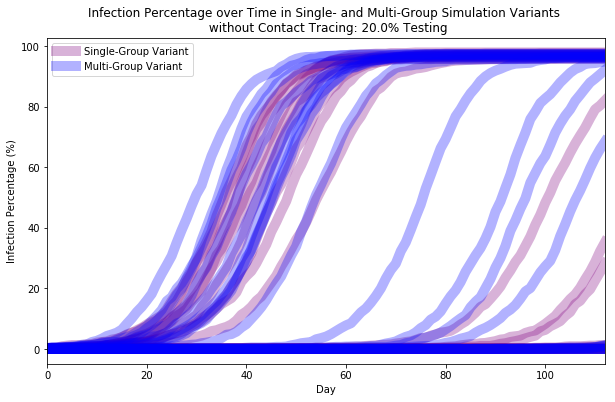

In [44]:
plt.figure(figsize=(10,6))
label='Single-Group Variant'
for df in single_grp_dfs:
    add_df_plot(df, label=label, color='purple', alpha=0.3, linewidth=10)
    label=''

label='Multi-Group Variant'
for df in multi_grp_dfs:
    add_df_plot(df, label=label, color='blue', alpha=0.3, linewidth=10)
    label=''

plt.xlabel("Day")
plt.ylabel("Infection Percentage (%)")
plt.legend()
plt.title("Infection Percentage over Time in Single- and Multi-Group Simulation Variants \n without Contact Tracing: {}% Testing".format(test_rate * 100))
plt.show()

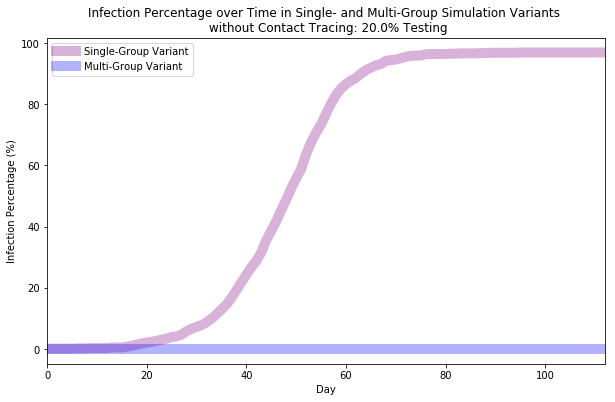

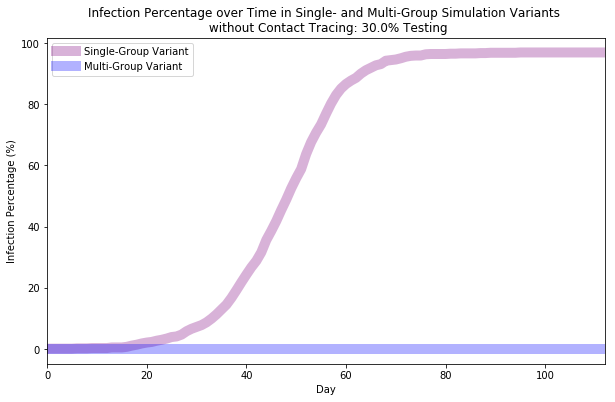

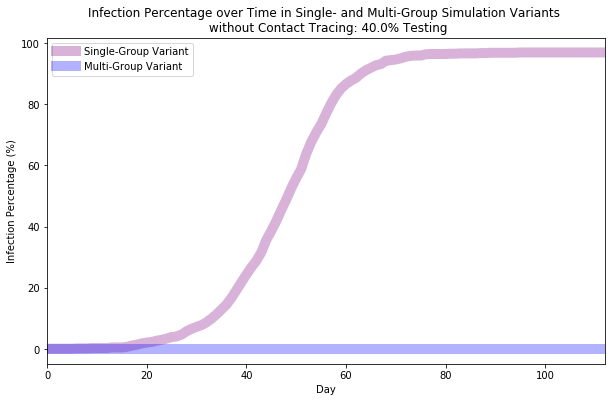

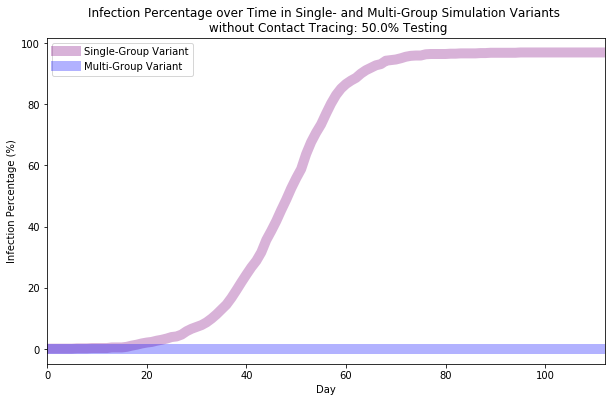

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_popsize(df):
    cols = df.columns
    subdf = df[[col for col in cols if 'cumulative' not in col]]
    return subdf.sum(axis=1).iloc[0]

def infection_pct(df):
    popsize = get_popsize(df)
    
    subdf = df[['cumulative_mild', 'cumulative_severe']]
    infections = subdf.sum(axis=1).iloc[-1]
    
    return infections / popsize * 100

def add_df_plot(df, label, color, alpha=0.1, linewidth=10):
    popsize = get_popsize(df)
    df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1) \
                        .plot(label=label, alpha=alpha, linewidth=linewidth, color=color)

def plot_infections(test_rate):
    plt.figure(figsize=(10,6))
    
    multi_grp_dfs = []
    single_grp_dfs = []
    
    for key, idx in args_to_idx.items():
        if key[2] != test_rate:
            continue
        val = return_dict[idx]
        if len(key) == 5:
            single_grp_dfs.append(val['sim_df'])
        else:
            multi_grp_dfs.append(val['sim_df'])
    
    label='Single-Group Variant'
    for df in single_grp_dfs:
        add_df_plot(df, label=label, color='purple', alpha=0.3, linewidth=10)
        label=''
    
    label='Multi-Group Variant'
    for df in multi_grp_dfs:
        add_df_plot(df, label=label, color='blue', alpha=0.3, linewidth=10)
        label=''
        
    plt.xlabel("Day")
    plt.ylabel("Infection Percentage (%)")
    plt.legend()
    plt.title("Infection Percentage over Time in Single- and Multi-Group Simulation Variants \n without Contact Tracing: {}% Testing".format(test_rate * 100))
    plt.show()
    
for test_rate in test_rates:
    plot_infections(test_rate)

In [53]:
len(args_to_idx)

8

In [52]:
len(return_dict)

800

In [34]:
list(return_dict.keys())[:10]

[(1000, 10, 0.2, 1.2e-05, 10, 11),
 (1000, 10, 0.2, 1.2e-05, 10, 15),
 (1000, 10, 0.2, 1.2e-05, 10, 21),
 (1000, 10, 0.2, 1.2e-05, 10, 1),
 (1000, 10, 0.2, 1.2e-05, 10, 13),
 (1000, 10, 0.2, 1.2e-05, 10, 7),
 (1000, 10, 0.2, 1.2e-05, 10, 3),
 (1000, 10, 0.2, 1.2e-05, 10, 5),
 (1000, 10, 0.2, 1.2e-05, 10, 9),
 (1000, 10, 0.2, 1.2e-05, 10, 17)]

In [39]:
return_dict[(1000, 10, 0.3, 1.2e-05, 10, 15)]['sim_df'].iloc[-1]

S                                     31
QS                                     0
QI                                    13
R                                    956
E_0                                    0
E_1                                    0
E_2                                    0
E_3                                    0
E_4                                    0
E_5                                    0
E_6                                    0
pre_ID_0                               0
pre_ID_1                               0
pre_ID_2                               0
pre_ID_3                               0
ID_0                                   0
ID_1                                   0
ID_2                                   0
ID_3                                   0
ID_4                                   0
ID_5                                   0
ID_6                                   0
ID_7                                   0
SyID_mild_0                            0
SyID_mild_1     

In [38]:
return_dict[(1000, 10, 0.2, 1.2e-05, 10, 17)]['sim_df'].iloc[-1]

S                                     31
QS                                     0
QI                                    13
R                                    956
E_0                                    0
E_1                                    0
E_2                                    0
E_3                                    0
E_4                                    0
E_5                                    0
E_6                                    0
pre_ID_0                               0
pre_ID_1                               0
pre_ID_2                               0
pre_ID_3                               0
ID_0                                   0
ID_1                                   0
ID_2                                   0
ID_3                                   0
ID_4                                   0
ID_5                                   0
ID_6                                   0
ID_7                                   0
SyID_mild_0                            0
SyID_mild_1     